# Coupling of modes (COM) analysis

This code was written to model surface aocustic wave (SAW) structures used in superconducting qubit/quantum acoustic experiments at the Labratory for Hybrid Quantum System (LHQS) at MSU. The COM equations are a set of differential equations for determining how a certain structure transduces and reflects SAWs. These equations are given general solutions in Chapter 8 of David Morgans "Surface Acoustic Wave Filters", 2nd edition. 

The COM equations are used to calculate elements of the so called P-matrix: a three port scattering matrix with two acoustic ports and one electrical port. The same geeral P-matrix solution may be used to simulate transducers, mirrors, and free propagation area, and more complex structures may be simulated by cascading P-matrices onto eachother. This notebook will go over how to implement these commands using the ```sawcom.py``` module.


In [ ]:
%matplotlib inline
import sawcom as sc
import numpy as np
import matplotlib.pyplot as plt

The functions in the sawcom module take several variables:

- The fundamental wavelength, or twice the transducer pitch (```lam```)
- The SAW velocity (```v```)
- The reflection per unit length (```c12```), which is generally 1-3% per finger
- The transduction coefficient (```a1```)
- The length of the SAW structure along the propagation path (```L```)

In addition, most functions also take ```delta```, the wavenumber detuning from the fundamental frequency. A function ```sc.delta(freq,v,lam)``` is provided to calculate delta at a given frequency. We may also make this wavenumber complex to simulate propagation loss.

As a demonstration, let's calculate the admittance of a 50 finger pair IDT structure for SAWs propagating on GaAs with a wavelength of 600 nm. We will calculate two scenarios: one where reflections are ignored, and one where reflections are taken into account.

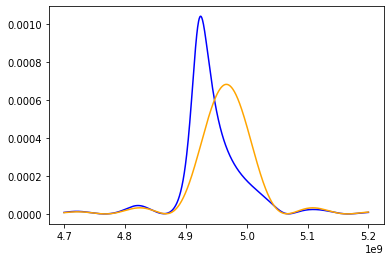

In [28]:
lam = 600E-9 # Wavelength in m
v = 2980 # velocity in m/s
c12 = -0.015j/(lam/2) # Reflectivity per unit length (~1.5% reflected per grating spaced at lam/2)
a1 = 617j
L = 30E-6 #Length of the grating, in m
freq = np.linspace(4.7E9, 5.2E9, 1001)
d = sc.delta(freq,v,lam) - 500j

idt50_ref = sc.pmatrix(lam,c12,a1,L,d) #transducer
idt50_ign = sc.pmatrix(lam,0,a1,L,d) #transducer


plt.plot(freq,idt50_ref.p33.real, color = 'blue')
plt.plot(freq,idt50_ign.p33.real, color = 'orange')

When we ignore reflections, we see a sinc function response. When reflections are taken into account, the sinc function is significantly distorted, skewing to one side, sharpening and peaking at a higher value. 

We may also use the same method to calculate the reflection from Bragg mirrors. Let's calculate the reflection off a Bragg mirror that is 300 µm long, with a fundamental frequency that is slightly *lower* than the IDT calculated above: this way, when we concatinate the structures, the peak of the skewed sinc function will fall into the stop band of the mirrors.

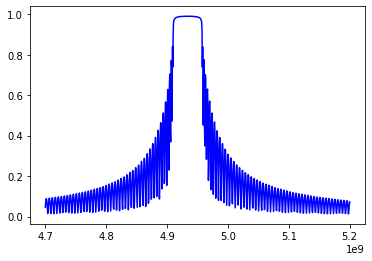

In [29]:
lam_mirror = lam*1.00666
len_mirror = 300E-6

d_mirror = sc.delta(freq,v,lam_mirror) - 500j

mirror = sc.pmatrix(lam_mirror,c12,0,len_mirror,d_mirror) #mirror

plt.plot(freq,np.abs(mirror.p11), color = 'blue')

Since ```pmatrix.p11``` encodes the reflection, we see that near the mirror fundamental frequency (the stopband) SAWs are reflected off the structure with neare unit probability.

The power of the P-matrix formalism is that we may now conatinate our individual structures into a resonator. The sawcom package has a function for doing this.

Here we sandwich an IDT inbetween two bragg mirrors and plot the conductance of the entire structure.

(-1e-05, 0.002)

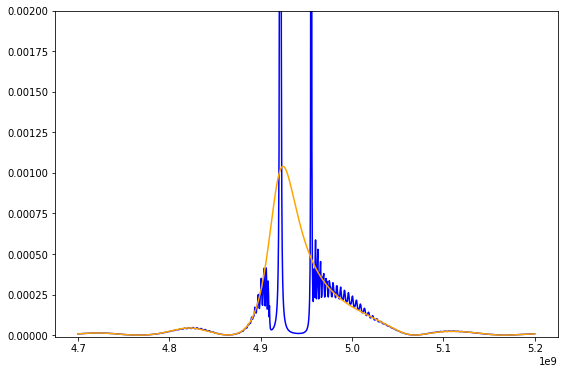

In [61]:
dict_1 = {'t':idt50_ref, 'm':mirror}
str_1 = 'mtm'

res = dict_1[str_1[0]]
for i in range(1,len(str_1)):
    res = sc.concat(res,dict_1[str_1[i]])


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (9,6))

ax.plot(freq,np.real(res.p33), color = 'blue')
ax.plot(freq,np.real(idt50_ref.p33), color = 'orange')
ax.set_ylim([-1E-5,0.002])

We may also simulate free propatation area using this code by setting both the transductance and the reflectance to zero. The more free propagation area we put between two structures, the further appart they are. As the two Bragg mirrors get farther appart, the free spectral range decreases, and we are able to see more resonances in the mirror stopband.

(-1e-05, 0.002)

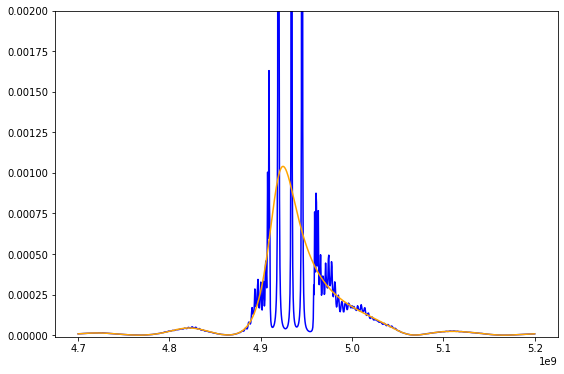

In [64]:
len_blank = 30E-6
blank = sc.pmatrix(lam,0,0,len_blank,d) # free propagation path

dict_2 = {'t':idt50_ref, 'm':mirror, 'b':blank}
str_2 = 'mbtbm'

res2 = dict_2[str_2[0]]
for i in range(1,len(str_2)):
    res2 = sc.concat(res2,dict_2[str_2[i]])


fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (9,6))

ax.plot(freq,np.real(res2.p33), color = 'blue')
ax.plot(freq,np.real(idt50_ref.p33), color = 'orange')

ax.set_ylim([-1E-5,0.002])